# Run a sktime model on Amazon SageMaker (Docker Mode) 

In [1]:
# install/upgrade needed package
# please restart the notebook after the installation finished
!pip install -q sktime
!pip install -q -U sagemaker

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Prepare our dataset

In [4]:
import pandas as pd
import numpy as np
from sktime.datasets import load_airline

airline_dataset = load_airline()
airline_dataset

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64

In [5]:
airline_dataset.to_csv('airline.csv')

## Make ECR Repo

In [86]:
import sagemaker

session = sagemaker.Session()
bucket = session.default_bucket()
account_id = session.boto_session.client('sts').get_caller_identity()['Account']
region = session.boto_session.region_name
image_name = 'sktime-naive-forecaster-demo'

### Run follwoing cell just for the first time

In [ ]:
%%bash -s "$region" "$image_name"
# define variables
export REGION=$1
export IMAGE_NAME=$2
aws ecr create-repository --repository-name $IMAGE_NAME --region $REGION

## Puch Docker to ECR Repo

In [ ]:
%%bash -s "$region" "$image_name"
# define variables
export REGION=$1
export IMAGE_NAME=$2

# Bulid the image
export ACCOUNT_ID=`aws sts get-caller-identity --query Account --output text`
docker build -t $IMAGE_NAME:latest -f Dockerfile .
export IMAGE_ID=`docker images -q $IMAGE_NAME:latest`

docker tag $IMAGE_ID $ACCOUNT_ID.dkr.ecr.$REGION.amazonaws.com/$IMAGE_NAME:latest
aws ecr get-login-password --region $REGION | docker login --username AWS --password-stdin $ACCOUNT_ID.dkr.ecr.$REGION.amazonaws.com/$IMAGE_NAME:latest
docker push $ACCOUNT_ID.dkr.ecr.$REGION.amazonaws.com/$IMAGE_NAME:latest

## Run Local

In [92]:
import sagemaker
from sagemaker.estimator import Estimator


training = 'file://.'
output = 'file://.'

role = sagemaker.get_execution_role()

sk_training = Estimator(
             image_uri=f'{account_id}.dkr.ecr.{region}.amazonaws.com/{image_name}:latest',
             role=role,
             instance_count=1, 
             instance_type='local',
             output_path=output,
             hyperparameters={
                  'normalize': True,
                  'test-size': 0.1,
                  'random-state': 123
             }
)

sk_training.fit({'training':training})

Creating rrpzavpao6-algo-1-fmvbr ... 
Creating rrpzavpao6-algo-1-fmvbr ... done
Attaching to rrpzavpao6-algo-1-fmvbr
rrpzavpao6-algo-1-fmvbr | *** sktime imported successfully ***
rrpzavpao6-algo-1-fmvbr | {'normalize': 'True', 'test-size': '0.1', 'random-state': '123'}
rrpzavpao6-algo-1-fmvbr | *** sMAPE Loss : 0.145427686270316 ***
rrpzavpao6-algo-1-fmvbr | *** Model has been saved ***
rrpzavpao6-algo-1-fmvbr exited with code 0
Aborting on container exit...
===== Job Complete =====


In [104]:
sk_predictor = sk_training.deploy(instance_type='local',
                        initial_instance_count=1)
sk_predictor.serializer = sagemaker.serializers.CSVSerializer()
sk_predictor.deserializer = sagemaker.deserializers.CSVDeserializer()

Attaching to 9oacuc3rpc-algo-1-jy7h3
9oacuc3rpc-algo-1-jy7h3 |  * Serving Flask app 'serve' (lazy loading)
9oacuc3rpc-algo-1-jy7h3 |  * Environment: production
9oacuc3rpc-algo-1-jy7h3 |    WARNING: This is a development server. Do not use it in a production deployment.
9oacuc3rpc-algo-1-jy7h3 |    Use a production WSGI server instead.
9oacuc3rpc-algo-1-jy7h3 |  * Debug mode: off
9oacuc3rpc-algo-1-jy7h3 |  * Running on all addresses.
9oacuc3rpc-algo-1-jy7h3 |    WARNING: This is a development server. Do not use it in a production deployment.
9oacuc3rpc-algo-1-jy7h3 |  * Running on http://172.18.0.2:8080/ (Press CTRL+C to quit)
9oacuc3rpc-algo-1-jy7h3 | 172.18.0.1 - - [13/Aug/2021 08:03:44] "GET /ping HTTP/1.1" 200 -
!

9oacuc3rpc-algo-1-jy7h3 | input:  1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
9oacuc3rpc-algo-1-jy7h3 | response:  315.0
9oacuc3rpc-algo-1-jy7h3 | 301.0
9oacuc3rpc-algo-1-jy7h3 | 356.0
9oacuc3rpc-algo-1-jy7h3 | 348.0
9oacuc3rpc-algo-1-jy7h3 | 355.0
9oacuc3rpc-algo-1-jy7h3 | 422.0
9oacuc3rpc-algo-1-jy7h3 | 465.0
9oacuc3rpc-algo-1-jy7h3 | 467.0
9oacuc3rpc-algo-1-jy7h3 | 404.0
9oacuc3rpc-algo-1-jy7h3 | 347.0
9oacuc3rpc-algo-1-jy7h3 | 305.0
9oacuc3rpc-algo-1-jy7h3 | 336.0
9oacuc3rpc-algo-1-jy7h3 | 315.0
9oacuc3rpc-algo-1-jy7h3 | 301.0
9oacuc3rpc-algo-1-jy7h3 | 356.0
9oacuc3rpc-algo-1-jy7h3 | 348.0
9oacuc3rpc-algo-1-jy7h3 | 355.0
9oacuc3rpc-algo-1-jy7h3 | 422.0
9oacuc3rpc-algo-1-jy7h3 | 465.0
9oacuc3rpc-algo-1-jy7h3 | 467.0
9oacuc3rpc-algo-1-jy7h3 | 404.0
9oacuc3rpc-algo-1-jy7h3 | 347.0
9oacuc3rpc-algo-1-jy7h3 | 305.0
9oacuc3rpc-algo-1-jy7h3 | 336.0
9oacuc3rpc-algo-1-jy7h3 | 315.0
9oacuc3rpc-algo-1-jy7h3 | 301.0
9oacuc3rpc-algo-1-jy7h3 

0.145427686270316

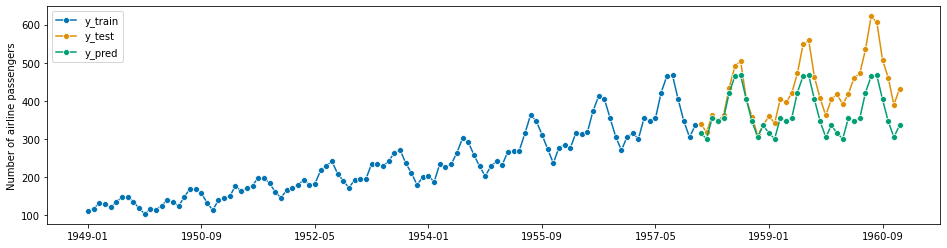

In [106]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series


y_train, y_test = temporal_train_test_split(dataset, test_size=36)

fh = np.arange(1, len(y_test) + 1)

y_pred = pd.Series([float(i[0]) for i in sk_predictor.predict(fh)], index=y_test.index)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

In [103]:
sk_predictor.delete_endpoint()

Gracefully stopping... (press Ctrl+C again to force)


## Create Training Job

In [ ]:
# Non Local
import sagemaker
from sagemaker.estimator import Estimator

                  
prefix = 'sktime-airline'

training = session.upload_data(path='airline.csv', key_prefix=prefix + "/training")
output   = 's3://{}/{}/output/'.format(bucket,prefix)

print(training)
print(output)

role = sagemaker.get_execution_role()

sk_training = Estimator(
             image_uri=f'{account_id}.dkr.ecr.{region}.amazonaws.com/{image_name}:latest',
             role=role,
             instance_count=1,
             instance_type='ml.m5.large',
             output_path=output,
             hyperparameters={
                  'normalize': True,
                  'test-size': 0.1,
                  'random-state': 123
             }
)

sk_training.fit({'training':training})

In [108]:
sk_predictor = sk_training.deploy(instance_type='ml.m5.large',
                                  initial_instance_count=1)
sk_predictor.serializer = sagemaker.serializers.CSVSerializer()
sk_predictor.deserializer = sagemaker.deserializers.CSVDeserializer()

-------------!

0.145427686270316

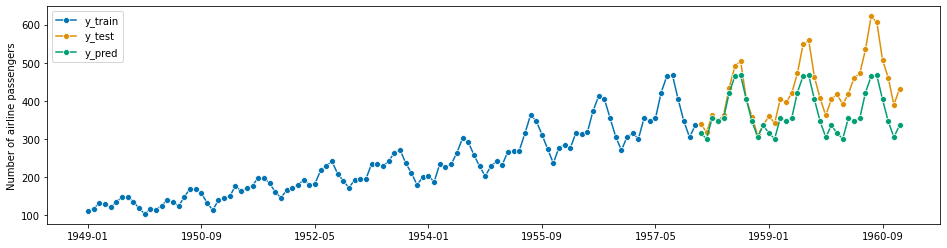

In [111]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series


y_train, y_test = temporal_train_test_split(dataset, test_size=36)

fh = np.arange(1, len(y_test) + 1)

y_pred = pd.Series([float(i[0]) for i in sk_predictor.predict(fh)], index=y_test.index)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

In [112]:
sk_predictor.delete_endpoint()